<a href="https://colab.research.google.com/github/Harishkumar01/IntrusionDetectionModel/blob/master/IntrusionDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating a Model for Network Intrusion Detection

Objective is to select best model to predict whether the given data packet is malicious or normal

This done by two steps which is proper preprocessing of data followed by training it to different models and validating the resuts.

In [1]:
#importing required modules
import pandas as pd
import seaborn as sns
import sklearn
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#mounting drive for importing dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#importing dataset
train_data = pd.read_csv("/content/drive/My Drive/ML_network_dataset/Train_data.csv")
test_data = pd.read_csv("/content/drive/My Drive/ML_network_dataset/Test_data.csv")

In [4]:
#displaying train and test data
print(train_data.head())
print(test_data.head())

   duration protocol_type  ... dst_host_srv_rerror_rate    class
0         0           tcp  ...                     0.00   normal
1         0           udp  ...                     0.00   normal
2         0           tcp  ...                     0.00  anomaly
3         0           tcp  ...                     0.01   normal
4         0           tcp  ...                     0.00   normal

[5 rows x 42 columns]
   duration protocol_type  ... dst_host_rerror_rate dst_host_srv_rerror_rate
0         0           tcp  ...                 1.00                     1.00
1         0           tcp  ...                 1.00                     1.00
2         2           tcp  ...                 0.00                     0.00
3         0          icmp  ...                 0.00                     0.00
4         1           tcp  ...                 0.83                     0.71

[5 rows x 41 columns]


## Preprocessing of data

The feature 'num_outbound_cmds' is redundant, so droping it.

In [6]:
train_data.drop(['num_outbound_cmds'], axis=1, inplace=True)
test_data.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [7]:
train_data['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

Procesing the numerical and catagorical data separately.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
 
columns_num = train_data.select_dtypes(include=['float64','int64']).columns
train_data_num = scaler.fit_transform(train_data.select_dtypes(include=['float64','int64']))
test_data_num = scaler.fit_transform(test_data.select_dtypes(include=['float64','int64']))
train_data_num = pd.DataFrame(train_data_num, columns = columns_num)
test_data_num = pd.DataFrame(test_data_num, columns = columns_num)

print(train_data_num.head())
print(test_data_num.head())

   duration  src_bytes  ...  dst_host_rerror_rate  dst_host_srv_rerror_rate
0 -0.113551  -0.009889  ...             -0.221668                 -0.374281
1 -0.113551  -0.010032  ...             -0.385140                 -0.374281
2 -0.113551  -0.010093  ...             -0.385140                 -0.374281
3 -0.113551  -0.009996  ...             -0.385140                 -0.342768
4 -0.113551  -0.010010  ...             -0.385140                 -0.374281

[5 rows x 37 columns]
   duration  src_bytes  ...  dst_host_rerror_rate  dst_host_srv_rerror_rate
0 -0.155534  -0.021988  ...              1.979791                  1.929116
1 -0.155534  -0.021988  ...              1.979791                  1.929116
2 -0.154113   0.005473  ...             -0.602719                 -0.565483
3 -0.155534  -0.021946  ...             -0.602719                 -0.565483
4 -0.154823  -0.021988  ...              1.540764                  1.205682

[5 rows x 37 columns]


In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train_data_cat = train_data.select_dtypes(include=['object']).copy()
test_data_cat = test_data.select_dtypes(include=['object']).copy()
train_data_cat = train_data_cat.apply(encoder.fit_transform)
test_data_cat = test_data_cat.apply(encoder.fit_transform)
train_data_cat_X = train_data_cat.drop(['class'], axis=1)
train_data_cat_Y = train_data_cat[['class']].copy()

In [10]:
train_x = pd.concat([train_data_num,train_data_cat_X],axis=1)
train_y = train_data['class']
train_x.shape
test_data_ = pd.concat([test_data_num,test_data_cat],axis=1)
test_data_.shape

(22544, 40)

Processed data

In [11]:
print(train_x.head())
print(train_y.head())
print(test_data_.head())

   duration  src_bytes  dst_bytes  ...  protocol_type  service  flag
0 -0.113551  -0.009889  -0.039310  ...              1       19     9
1 -0.113551  -0.010032  -0.039310  ...              2       41     9
2 -0.113551  -0.010093  -0.039310  ...              1       46     5
3 -0.113551  -0.009996   0.052473  ...              1       22     9
4 -0.113551  -0.010010  -0.034582  ...              1       22     9

[5 rows x 40 columns]
0     normal
1     normal
2    anomaly
3     normal
4     normal
Name: class, dtype: object
   duration  src_bytes  dst_bytes  ...  protocol_type  service  flag
0 -0.155534  -0.021988  -0.096896  ...              1       45     1
1 -0.155534  -0.021988  -0.096896  ...              1       45     1
2 -0.154113   0.005473  -0.096896  ...              1       19     9
3 -0.155534  -0.021946  -0.096896  ...              0       13     9
4 -0.154823  -0.021988  -0.096189  ...              1       55     2

[5 rows x 40 columns]


Performing **Forward Selection** for feature Selection

In [ ]:
#increse the number of features to be selected as needed(as of now its set to 15 out of 40)
forwardres = SFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs = -1),
         k_features = 15,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1
         ).fit(train_x, train_y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished

[2020-07-13 06:32:30] Features: 1/15 -- score: 0.962289615751032[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:  1.9min finished

[2020-07-13 06:34:27] Features: 2/15 -- score: 0.9875357256271832[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:  2.0min finished

[2020-07-13 06:36:26] Features: 3/15 -- score: 0.9939663385201651[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:  2.0min finished

[2020-07-13 06:38:23] Features: 4/15 -- score: 0.9959114004445856[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n

In [13]:
#selected features and resulting dataset
features = pd.array(forwardres.k_feature_names_)
print(features)
traindata_ = train_x[features]
print(traindata_.head())

['duration', 'src_bytes', 'dst_bytes', 'land', 'su_attempted', 'num_file_creations', 'srv_rerror_rate', 'same_srv_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'protocol_type', 'service', 'flag']
   duration  src_bytes  dst_bytes  ...  protocol_type  service  flag
0 -0.113551  -0.009889  -0.039310  ...              1       19     9
1 -0.113551  -0.010032  -0.039310  ...              2       41     9
2 -0.113551  -0.010093  -0.039310  ...              1       46     5
3 -0.113551  -0.009996   0.052473  ...              1       22     9
4 -0.113551  -0.010010  -0.034582  ...              1       22     9

[5 rows x 15 columns]


# Training the models

In [14]:
#splitting train to train and test to feed the model and evaluate
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(traindata_,train_y,train_size=0.70, random_state=2)

In [21]:
#Selected models
selected_models = []

#SVM Classifier
#KNeighborsClassifier Model
#LogisticRegression Model
#NaiveBayes Model
#DecisionTree Model

from sklearn.svm import SVC
SVM_Classifier = SVC(kernel='rbf', random_state = 1)
SVM_Classifier.fit(X_train,Y_train)

from sklearn.naive_bayes import BernoulliNB 
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)

from sklearn import tree
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

from sklearn.neighbors import KNeighborsClassifier
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train)

from sklearn.linear_model import LogisticRegression
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train)

selected_models.append(('SVM Classifier', SVM_Classifier))
selected_models.append(('Naive Baye Classifier', BNB_Classifier))
selected_models.append(('Decision Tree Classifier', DTC_Classifier))
selected_models.append(('KNeighborsClassifier', KNN_Classifier))
selected_models.append(('LogisticRegression', LGR_Classifier))



In [35]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

for i, j in selected_models:

    print(i)

    classification = metrics.classification_report(Y_train, j.predict(X_train))
    print("Classification report:" "\n", classification)

    scores = cross_val_score(j, X_train, Y_train, cv=10)
    print("Cross Validation Score: ", scores.mean())

    accuracy = metrics.accuracy_score(Y_train, j.predict(X_train))
    print("Accuracy: ", accuracy)

    confusion_matrix = metrics.confusion_matrix(Y_train, j.predict(X_train))
    print("Confusion matrix:" "\n", confusion_matrix)

    print() 



SVM Classifier
Classification report:
               precision    recall  f1-score   support

     anomaly       0.97      0.92      0.95      8245
      normal       0.94      0.98      0.96      9389

    accuracy                           0.95     17634
   macro avg       0.95      0.95      0.95     17634
weighted avg       0.95      0.95      0.95     17634

Cross Validation Score:  0.9509467731127239
Accuracy:  0.952534875808098
Confusion matrix:
 [[7616  629]
 [ 208 9181]]

Naive Baye Classifier
Classification report:
               precision    recall  f1-score   support

     anomaly       0.94      0.82      0.87      8245
      normal       0.86      0.95      0.90      9389

    accuracy                           0.89     17634
   macro avg       0.90      0.89      0.89     17634
weighted avg       0.89      0.89      0.89     17634

Cross Validation Score:  0.8898706145343371
Accuracy:  0.8898718384938188
Confusion matrix:
 [[6748 1497]
 [ 445 8944]]

Decision Tree Classi

In [45]:
#Testing the models
accuracyofmodels = []

for i, j in selected_models:

    print(i)

    classification = metrics.classification_report(Y_test, j.predict(X_test))
    print("Classification report:" "\n", classification)

    accuracy = metrics.accuracy_score(Y_test, j.predict(X_test))
    print ("Accuracy: ", accuracy)

    confusion_matrix = metrics.confusion_matrix(Y_test, j.predict(X_test))
    print("Confusion matrix:" "\n"  , confusion_matrix)
     
    accuracyofmodels.append(accuracy)

    print()

print(accuracyofmodels)
best_model = accuracyofmodels.index(max(accuracyofmodels))
print(best_model)   

SVM Classifier
Classification report:
               precision    recall  f1-score   support

     anomaly       0.97      0.93      0.95      3498
      normal       0.94      0.98      0.96      4060

    accuracy                           0.95      7558
   macro avg       0.96      0.95      0.95      7558
weighted avg       0.96      0.95      0.95      7558

Accuracy:  0.9543530034400635
Confusion matrix:
 [[3246  252]
 [  93 3967]]

Naive Baye Classifier
Classification report:
               precision    recall  f1-score   support

     anomaly       0.93      0.82      0.87      3498
      normal       0.86      0.95      0.90      4060

    accuracy                           0.89      7558
   macro avg       0.89      0.88      0.89      7558
weighted avg       0.89      0.89      0.89      7558

Accuracy:  0.8885948663667637
Confusion matrix:
 [[2876  622]
 [ 220 3840]]

Decision Tree Classifier
Classification report:
               precision    recall  f1-score   support

   

Predicting the state of the packet using the best trained model

Best model for given dataset is [Decision Tree Classifier] and evaluating test dataset based on that model
   duration  src_bytes  dst_bytes  ...  service  flag        0
0 -0.155534  -0.021988  -0.096896  ...       45     1  anomaly
1 -0.155534  -0.021988  -0.096896  ...       45     1  anomaly
2 -0.154113   0.005473  -0.096896  ...       19     9   normal
3 -0.155534  -0.021946  -0.096896  ...       13     9  anomaly
4 -0.154823  -0.021988  -0.096189  ...       55     2  anomaly

[5 rows x 41 columns]


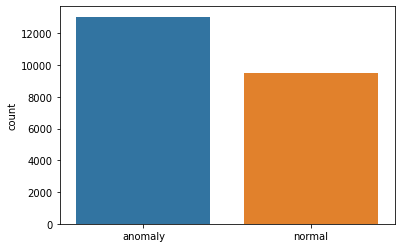

In [46]:
#selecting features in test data
testdata_ = test_data_[features]
#Predicting the nature of packets using the best model selected
if best_model == 0:
  print("Best model for given dataset is [SVM classifier] and evaluating test dataset based on that model")
  pred_SVM = SVM_Classifier.predict(testdata_)
  pred_SVM_list = list(pred_SVM)
  pred_SVM = pd.DataFrame(pred_SVM)
  result = pd.concat([test_data_, pred_SVM],axis=1)
  result.shape
  print(result.head())
  sns.countplot(pred_SVM_list)
elif best_model == 1:
  print("Best model for given dataset is [Naive Baye Classifier] and evaluating test dataset based on that model")
  pred_NB = BNB_Classifier.predict(testdata_)
  pred_NB_list = list(pred_NB)
  pred_NB = pd.DataFrame(pred_NB)
  result = pd.concat([test_data_, pred_NB],axis=1)
  result.shape
  print(result.head())
  sns.countplot(pred_NB_list)
elif best_model == 2:
  print("Best model for given dataset is [Decision Tree Classifier] and evaluating test dataset based on that model")
  pred_dt = DTC_Classifier.predict(testdata_)
  pred_dtc_list = list(pred_dt)
  pred_dt = pd.DataFrame(pred_dt)
  result = pd.concat([test_data_, pred_dt],axis=1)
  result.shape
  print(result.head())
  sns.countplot(pred_dtc_list)
elif best_model == 3:
  print("Best model for given dataset is [KNeighbors Classifier] and evaluating test dataset based on that model")
  pred_knn = KNN_Classifier.predict(testdata_)
  pred_knn_list = list(pred_knn)
  pred_knn = pd.DataFrame(pred_knn)
  result = pd.concat([test_data_, pred_knn],axis=1)
  result.shape
  print(result.head())
  sns.countplot(pred_knn_list)
else:
  print("Best model for given dataset is [LogisticRegression] and evaluating test dataset based on that model")
  pred_log = LGR_Classifier.predict(testdata_)
  pred_log_list = list(pred_log)
  pred_log = pd.DataFrame(pred_log)
  result = pd.concat([test_data_, pred_log],axis=1)
  result.shape
  print(result.head())
  sns.countplot(pred_log_list)
  


In [40]:
result[0].value_counts()

normal     14416
anomaly     8128
Name: 0, dtype: int64

Hence, the packet of class anomaly are malicious.


# Thank You